In [1]:
import csv
import torch
import numpy as np
import pandas as pd

fields = ['input1', 'input2','output1', 'output2']
rows = []
h_target = torch.tensor([[1.,1.],[1.,-1]] / np.sqrt(2), dtype=torch.complex128)
x_target = torch.tensor([[0.,1.],[1.,0.]], dtype=torch.complex128)
z_target = torch.tensor([[1.,0.],[0.,-1.]], dtype=torch.complex128)

for i in range(8):
    phi = np.random.rand() * 2*np.pi
    theta = np.random.rand() * np.pi
    
    input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
    output = h_target @ input_qubit

    rows.append([np.sin(theta), np.cos(theta) * np.exp(1j * phi), output[0].item(), output[1].item()])

filename = 'qubit.csv'

with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

In [2]:
df = pd.read_csv('qubit.csv')
df

,input1,input2,output1,output2
0,0.474827,(0.38476741900497863-0.7915131619412096j),(0.6078252421634905-0.5596843242070352j),(0.06368193984735848+0.5596843242070352j)
1,0.388409,(0.40119195337626873-0.8295681435420967j),(0.5583323346470785-0.5865932597549518j),(-0.009038766932595088+0.5865932597549518j)
2,0.665070,(0.6913095309064529+0.2824412048650696j),(0.9591051606432568+0.19971609124658957j),(-0.018554153762431025-0.19971609124658957j)
3,0.988384,(-0.07928075784657485+0.1296570154985216j),(0.6428333135401408+0.0916813548874139j),(0.7549532365219841-0.0916813548874139j)
4,0.986524,(-0.13782214027122636-0.08817814766057389j),(0.6001228650737823-0.062351366163260494j),(0.7950328050406378+0.062351366163260494j)
5,0.751186,(0.5573526579942629-0.35366242710022183j),(0.9252767918132208-0.2500771004534599j),(0.13706110385304093+0.2500771004534599j)
6,0.737457,(-0.6475681575983349+0.19186778958112394j),(0.06356072511214311+0.13567101510408633j),(0.9793603961486661-0.13567101510408633j)
7,0.127826,(0.9828471417292867-0.13293646006793744j),(0.7853642538084334-0.09400027238097325j),(-0.6045915037647552+0.09400027238097325j)


epoch: 0, loss: 0.48349770381898644
epoch: 500, loss: 0.30019115492436776
epoch: 1000, loss: 0.14729672384551007
epoch: 1500, loss: 0.00655301995511183
epoch: 2000, loss: 7.407011757065707e-05
epoch: 2500, loss: 1.751178307085599e-07
epoch: 3000, loss: 5.269715219746729e-11
tensor([0.7071-1.6182e-17j, 0.7071+7.3075e-06j], dtype=torch.complex128,
       grad_fn=<MulBackward0>)
tensor([0.7071-1.6182e-17j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j,
        0.7071+7.3075e-06j], dtype=torch.complex128,
       grad_fn=<SqueezeBackward4>)


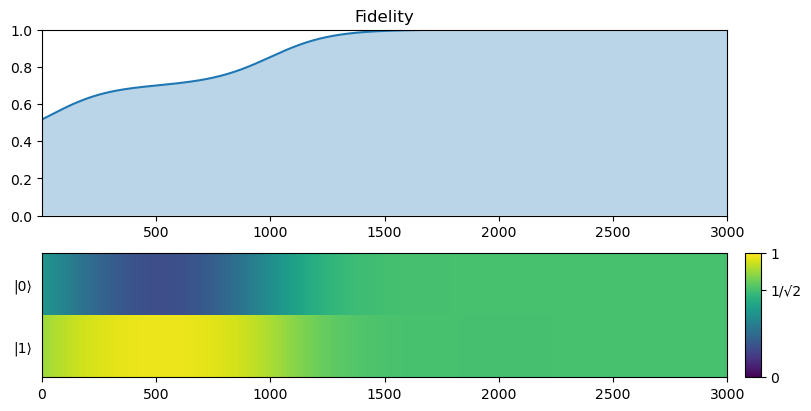

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

num_qubits = 8

n_ghz = 4

batch_size = 8

num_epochs = 3001

learning_rate = 1e-3

loss_graph = []

q1_graph = []
q2_graph = []


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)

#===============================================================================================================================
#Create the data set

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.df = pd.read_csv('qubit.csv')
        self.df['input1'] = self.df['input1'].astype(complex)
        self.df['input2'] = self.df['input2'].astype(complex)
        self.df['output1'] = self.df['output1'].astype(complex)
        self.df['output2'] = self.df['output2'].astype(complex)

        dataset = []
        labels = []

        for i in range(num_qubits):
            dataset.append([self.df['input1'][i],self.df['input2'][i]])
            
        self.dataset = torch.tensor(dataset, dtype=torch.complex128)
        
        for i in range(num_qubits):
            labels.append([self.df['output1'][i],self.df['output2'][i]])
        
        self.labels = torch.tensor(labels, dtype=torch.complex128)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]
    
#===============================================================================================================================
#Load the data set

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================
#The model

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
      
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ

        U = elements_to_matrix(
            [[torch.exp(1j * α) * torch.cos(θ), torch.exp(1j * β) * torch.sin(θ)],
             [- torch.exp(-1j * β) * torch.sin(θ), torch.exp(-1j * α) * torch.cos(θ)]])
        
        if len(x.shape) == 1:
            return U.matmul(x)
        else:
            q_test = torch.tensor([1,0], dtype=torch.complex128, requires_grad=False)
            out = U @ q_test
            q1_graph.append(abs(out[0].tolist()))
            q2_graph.append(abs(out[1].tolist()))
            
            return torch.einsum('ij,bj->bi', U, x)        

#===============================================================================================================================
#Loss function

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================
#Train the model

model = HModel()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
#===============================================================================================================================
#Test the model

model.eval()

q0 = model(torch.tensor([1,0],dtype=torch.complex128, requires_grad=False))
q1 = torch.tensor([1,0],dtype=torch.complex128, requires_grad=False)

fake_global_phase = torch.angle(q0[0])
q0 = torch.exp(-1j * fake_global_phase) * q0
print(q0)

for n in range(n_ghz-1):
    q0 = torch.kron(q0,q1)
    q0 = q0 @ c_not
    c_not = torch.kron(i,c_not)
print(q0)

#===============================================================================================================================
#Graph the progress of the model

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1.5,1), layout='constrained')

x_graph = np.arange(num_epochs * num_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * num_qubits / batch_size))

q12_graph = np.array([q2_graph,q1_graph])

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = ax2.pcolormesh(q12_graph, norm=norm, cmap='viridis')

cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=8)
cbar.set_ticks([0, 1/np.sqrt(2), 1])
cbar.set_ticklabels(["0", "1/√2", "1"])

ax2.set_yticks([0.5,1.5], labels=['|1⟩','|0⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * num_qubits / batch_size-1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

#===============================================================================================================================
#Suppress console output

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout